In [29]:
# 应该如何对待t检验的null result
# 是支持H0还是数据太少不足以拒绝H0

import pymc as pm
import arviz as az

from scipy.stats import beta, gamma, norm, cauchy
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from pytensor import tensor as pt 

## 8.1 One Sample Comparison

虚无假设是 $\mu = 0$，备择假设是 $\mu\neq0$，而 $\sigma$ 是未知的。

效应量effect size是比均值差异更容易进行比较的统计量
- 标准差先验分布：柯西分布，$f(x) = \frac{1}{\pi(1+x^2)}$，是一个没有期望的厚尾分布
- 效应量先验分布：柯西分布，柯西分布是自由度为1的t分布



In [57]:
x_obs = np.array([0, 2, -2, -1, 1]) # 无效应的例子
with pm.Model() as OneSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
az.summary(trace)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,0.003,0.399,-0.700,0.796,0.005,0.005,6632.0,4832.0,1.0
sigma,1.580,0.567,0.748,2.603,0.007,0.012,6809.0,5028.0,1.0
mu,0.006,0.673,-1.286,1.292,0.008,0.010,7125.0,5592.0,1.0


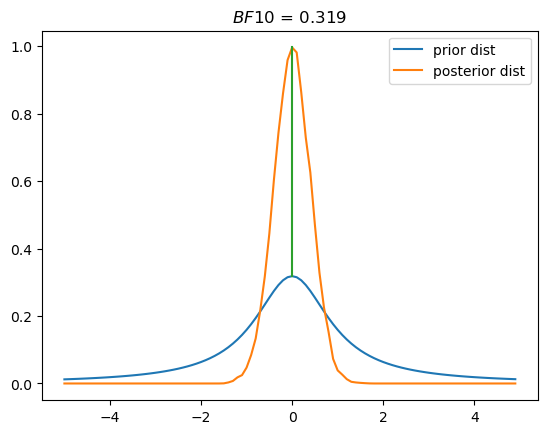

In [58]:
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()


In [59]:
# Exercise 8.1.2
## sigma改成使用一个beta分布
x_obs = np.array([0, 2, -2, -1, 1]) # 无效应的例子
with pm.Model() as OneSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    lamb = pm.Gamma('lamb', alpha = 0.001, beta = 0.001)
    mu = pm.Deterministic('mu', delta / lamb**0.5)
    x_obs = pm.Normal('x', mu = mu, tau = lamb, observed = x_obs)
    trace = pm.sample(2000)
az.summary(trace)
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, lamb]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.001,0.401,-0.741,0.777,0.005,0.005,6336.0,4931.0,1.0
lamb,0.498,0.310,0.037,1.063,0.004,0.005,6076.0,4489.0,1.0
mu,-0.004,0.737,-1.416,1.343,0.009,0.024,6848.0,5346.0,1.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


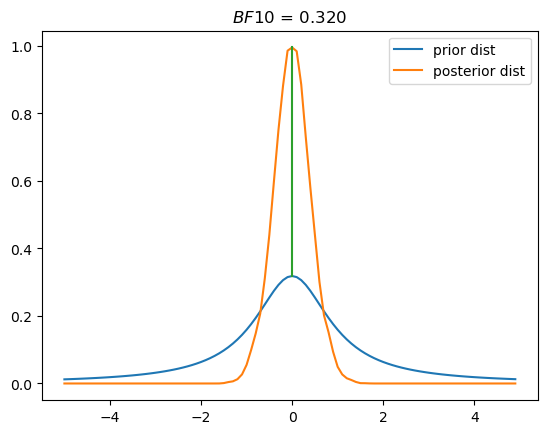

In [61]:
x_obs = np.array([0, 2, -2, -1, 1]) # 无效应的例子
with pm.Model() as OneSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 5)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


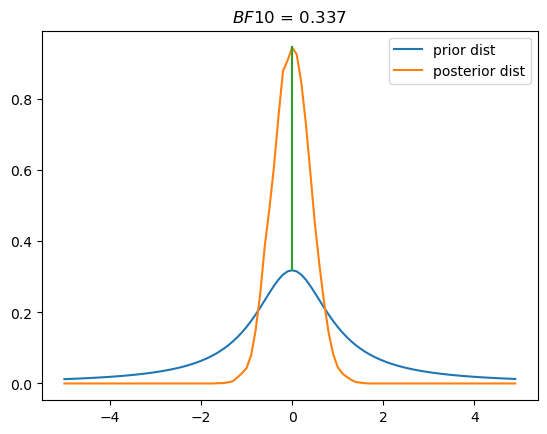

In [62]:
# Exercise 8.1.3
## 效应量改成正态分布，一开始就假设了绝对值更小的效应量
x_obs = np.array([0, 2, -2, -1, 1]) # 无效应的例子
with pm.Model() as OneSampleComp:
    delta = pm.Normal('delta', mu = 0, sigma = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
az.summary(trace)
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


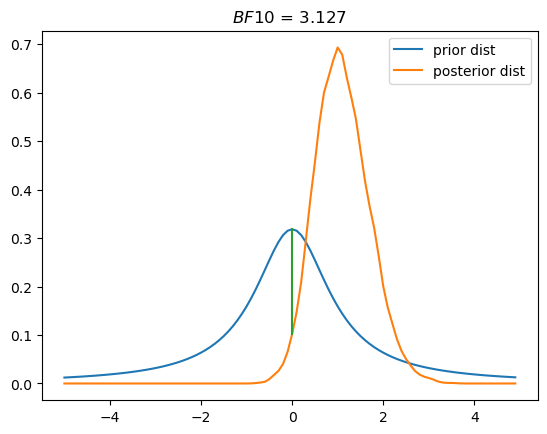

In [84]:
# 单样本检验在不同模型上的例子
x_obs = np.array([0, 2, -2, -1, 1]) + 2 # 有效应的例子
with pm.Model() as OneSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
az.summary(trace)
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()

## 8.2 One Sample Ordered Comparison

如果备择假设是效应量 $\delta$ 只能是负的呢？很自然的假设就是负的先验分布
- 这里值得注意的是，H0和H1似乎不再需要是互补的了

In [66]:
x_obs = np.array([0, 2, -2, -1, 1]) + 2 # 有效应的例子
with pm.Model() as OneSampleOrdered:
    delta = pm.HalfCauchy('delta', beta = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


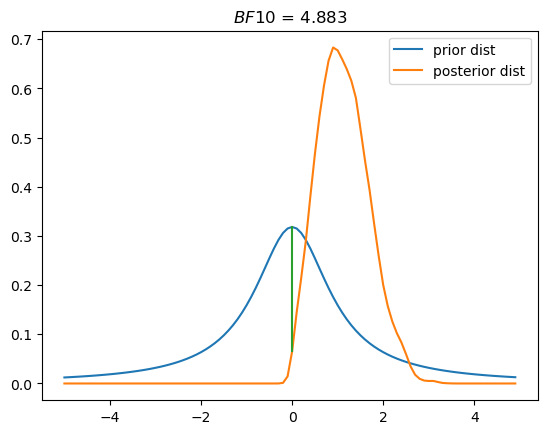

In [68]:
# 当固定方向后，BF从2.797增加到4.883
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pos_delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


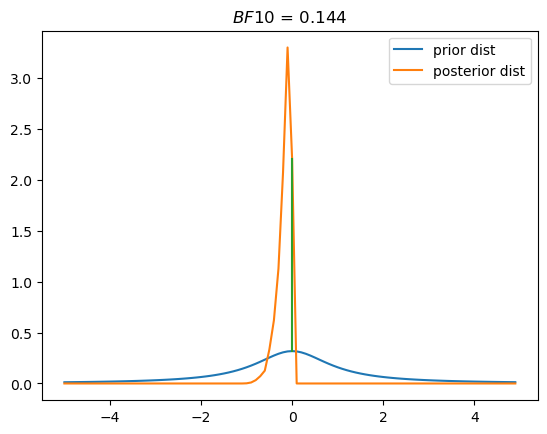

In [72]:
# Exercise 8.2.1
## 我们发现改用另一侧，BF变成0.144，中等支持原假设，方向很重要
x_obs = np.array([0, 2, -2, -1, 1]) + 2 # 有效应的例子
with pm.Model() as OneSampleOrdered:
    pos_delta = pm.HalfCauchy('pos_delta', beta = 1)
    delta = pm.Deterministic('delta', -pos_delta)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
az.summary(trace)
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()

In [73]:
# 单样本检验在不同模型上的例子
x_obs = np.array([0, 2, -2, -1, 1]) + 2 # 有效应的例子
with pm.Model() as OneSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    x_obs = pm.Normal('x', mu = mu, sigma = sigma, observed = x_obs)
    trace = pm.sample(2000)
# az.summary(trace)
# x_test = np.arange(-5, 5, 0.1)
# prior_pdf = cauchy.pdf
# posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
# plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
# plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
# plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
# plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
# plt.legend()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


In [95]:
# Exercise 8.2.3 
## 使用积分算法解决Ordered问题
prior_at_0 = cauchy.pdf(0)
delta_trace = trace.posterior['delta'].values.flatten()
posterior_at_0 = gaussian_kde(delta_trace)(0)[0]
BF_NP = prior_at_0 / posterior_at_0
BF_P = (prior_at_0 * 2) / (posterior_at_0 / (delta_trace >= 0).mean())
BF_N = (prior_at_0 * 2) / (posterior_at_0 / (delta_trace <= 0).mean())
BF_NP, BF_P, BF_N #这个结果没有期望的那么稳定

(3.126517368797106, 6.1334454482377225, 0.11958928935648931)

## 8.3 Two Sample Comparison
没有很具体的讲背景知识，只是很直接的在方差齐性条件下做独立样本t检验了


In [110]:
x_obs, y_obs = np.random.normal(0, 1, 10), np.random.normal(1, 2, 10)

In [114]:
x_obs.mean(), x_obs.std(), y_obs.mean(), y_obs.std()

(-0.12441185662621838,
 0.9682956811257522,
 0.44662123753176425,
 1.8606430599948989)

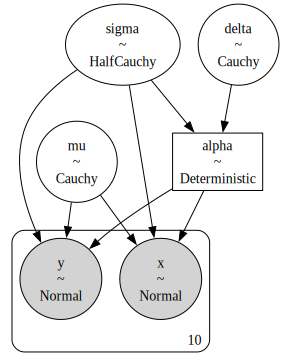

In [115]:
with pm.Model() as TwoSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    mu = pm.Cauchy('mu', alpha = 0, beta = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    alpha = pm.Deterministic('alpha', delta * sigma)
    x = pm.Normal('x', mu = mu + alpha / 2, sigma = sigma, observed = x_obs)
    y = pm.Normal('y', mu = mu - alpha / 2, sigma = sigma, observed = y_obs)
pm.model_to_graphviz(TwoSampleComp)


In [116]:
with TwoSampleComp:
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.294,0.406,-1.108,0.411,0.004,0.004,9079.0,6174.0,1.0
mu,0.139,0.327,-0.476,0.756,0.004,0.004,8506.0,5663.0,1.0
sigma,1.564,0.258,1.123,2.051,0.003,0.003,7936.0,5299.0,1.0
alpha,-0.447,0.638,-1.610,0.763,0.007,0.007,9377.0,6293.0,1.0


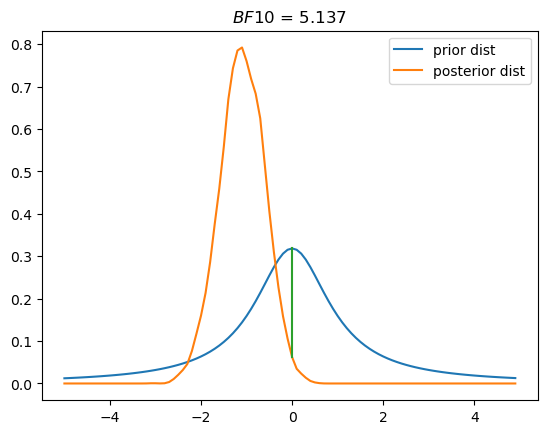

In [107]:
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()

In [113]:
# Exercise 8.3.1
## 假定方差不同引入了额外的变异，更难得到结论
with pm.Model() as TwoSampleComp:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    mu = pm.Cauchy('mu', alpha = 0, beta = 1)
    sigma1 = pm.HalfCauchy('sigma1', beta = 1)
    sigma2 = pm.HalfCauchy('sigma2', beta = 1)
    sigma = pm.Deterministic('sigma', (sigma1**2 + sigma2**2)**0.5)
    x = pm.Normal('x', mu = mu + delta * sigma / 2, sigma = sigma1, observed = x_obs)
    y = pm.Normal('y', mu = mu - delta * sigma / 2, sigma = sigma2, observed = y_obs)
    trace = pm.sample(2000)
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, mu, sigma1, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.168,0.218,-0.578,0.233,0.003,0.002,5644.0,5206.0,1.0
mu,0.126,0.330,-0.523,0.713,0.005,0.004,4881.0,4828.0,1.0
sigma1,1.084,0.269,0.638,1.549,0.004,0.006,6129.0,4218.0,1.0
sigma2,1.972,0.469,1.193,2.819,0.007,0.010,5772.0,4497.0,1.0
alpha,-0.499,0.674,-1.839,0.700,0.009,0.008,5645.0,5160.0,1.0


In [ ]:
x_test = np.arange(-5, 5, 0.1)
prior_pdf = cauchy.pdf
posterior_pdf = gaussian_kde(trace.posterior['delta'].values.flatten())
plt.plot(x_test, prior_pdf(x_test), label = 'prior dist')
plt.plot(x_test, posterior_pdf(x_test), label = 'posterior dist')
plt.plot([0, 0], [prior_pdf(0), posterior_pdf(0)[0]])
plt.title(f'$BF{10}$ = {prior_pdf(0) / posterior_pdf(0)[0]:.3f}')
plt.legend()